In [3]:
import os
import math
from math import ceil

import re
import random
import time
import json

from tqdm import tqdm_notebook
from collections import Counter, defaultdict
from operator import itemgetter
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup as BS

import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

import pymorphy2

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
stopwords = set(stopwords.words('russian'))

import scipy
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering as agg_clustering

pd.options.display.max_columns = 50

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Word frequency

In [4]:
# media_outlets = dict({'media':[files]})

In [2]:
def count_frequencies(text, media):

    words = re.split(r'\W+', text)

    words_counter = Counter(words)

    vocab = defaultdict(int)
    morph = pymorphy2.MorphAnalyzer()
    for i in tqdm_notebook(dict(words_counter).keys()):
        if i and i not in stopwords:
            m = morph.parse(i)[0]
            if m.tag.POS not in ['PREP', 'CONJ', 'PRCL', 'INTJ', 'NPRO']:
                vocab[m.normal_form] += words_counter[i]
    
    unique_words = []
    for j in dict(vocab):
        i = re.sub(r'ё', 'е', j)
        if i in freq.index:
            vocab[j] *= 1000000/len(words)
            vocab[j] = round(vocab[j]/freq.loc[i, 'Freq(ipm)'])
        else:
            unique_words.append(i)

    frequencies = pd.DataFrame(sorted(dict(vocab).items(), key=lambda x: x[1], reverse=True))
    frequencies.to_csv(f'{media}_freq_full.csv')
    frequencies[:100].to_csv(f'{media}_freq_top.csv')
    
    with open(f'{media}_unique_words.txt', 'w', encoding = 'utf-8') as f:
        f.write(', '.join(set(unique_words)))

In [125]:
freq = pd.read_csv('freqrnc2011.csv', sep='\t', index_col='Lemma')
freq = freq.groupby(level=0).sum()

for media in tqdm_notebook(media_outlets.keys()):
    text = []
    for file in media_outlets[media]:
        df = pd.read_csv(file)
        text.append(' '.join(df[df.Text.notnull()].Text))
    text = ' '.join(text).replace('\n', ' ')
    with open (f'{media}_text.txt', 'w', encoding='utf-8') as f:
        f.write(text)
    count_frequencies(text, media)

In [126]:
l = [file for file in os.listdir() if 'freq_full' in file][:-1]
for file in tqdm_notebook(l):
    df = pd.read_csv(file)
    df[(df['0'].notnull())&(df['0'].str.isalpha())].to_csv(file.split('.')[0]+'_words.'+file.split('.')[1])

In [23]:
l = [file for file in os.listdir() if 'freq_full_words' in file]
for file in l[:-1]:
    df = pd.read_csv(file)
    print(len(df), file)

144387 aif_freq_full_words.csv
7175 autonews_freq_full_words.csv
60814 championat_freq_full_words.csv
257604 commers_freq_full_words.csv
111751 echo_freq_full_words.csv
24220 express_freq_full_words.csv
193428 gazeta_freq_full_words.csv
54130 govorit_freq_full_words.csv
34486 indicator_freq_full_words.csv
104997 interfax_freq_full_words.csv
173204 iz_freq_full_words.csv
281972 kp_freq_full_words.csv
138905 lenta_freq_full_words.csv
44792 mediazona_freq_full_words.csv
93113 meduza_freq_full_words.csv
119435 mk_freq_full_words.csv
34927 motor_freq_full_words.csv
73891 novaya_freq_full_words.csv
34064 nplus1_freq_full_words.csv
88609 ntv_freq_full_words.csv
30299 postnauka_freq_full_words.csv
17721 radiovesti_freq_full_words.csv
94115 rbk_freq_full_words.csv
28879 review_freq_full_words.csv
193729 ria_freq_full_words.csv
240188 rosgazeta_freq_full_words.csv
108803 rt_freq_full_words.csv
88514 sports_freq_full_words.csv
108392 svoboda_freq_full_words.csv
194560 tass_freq_full_words.csv
278

In [80]:
keywords = set()
l = [file for file in os.listdir() if 'freq_full_words' in file]
for file in tqdm_notebook(l):
    df = pd.read_csv(file)
    keywords.update(list(df[(df['0'].notnull())&(df['0'].str.isalpha())&(df['0'].str.len()>1)]['0'][:1000]))

In [81]:
len(keywords)

9098

In [82]:
with open('keywords.txt', 'w', encoding='utf-8') as f:
    f.write(' '.join(keywords))

In [10]:
with open('keywords.txt', encoding='utf-8') as f:
    keywords = f.read().split()

In [12]:
w = pd.DataFrame(keywords)
for file in [file for file in os.listdir() if file.endswith('words.csv')]:
    media = file.split('_')[0]
    df = pd.read_csv(file)
    if 'Unnamed: 0.1' in df.columns:
        df.drop(['Unnamed: 0.1'], axis=1, inplace=True)
    if 'Unnamed: 0' in df.columns:
        df.drop(['Unnamed: 0'], axis=1, inplace=True)
    try:
        w = w.merge(df, how='left', left_on=0, right_on='0').drop(['0'], axis=1).rename(columns={'1':media})
    except KeyError:
        print(file) 

In [13]:
w = w.fillna(0)
w['sum'] = w.sum(axis=1)
# w.sort_values('sum', ascending=False).to_csv('keywords_top1000.csv')
w = w.sort_values('sum', ascending=False).rename(columns={0:'word'})
m = pymorphy2.MorphAnalyzer()
w[['Name' not in m.parse(e)[0].tag for e in w['word']]].head(15)

,word,aif,autonews,championat,commers,echo,express,fontanka,gazeta,govorit,indicator,interfax,iz,kp,lenta,mediazona,meduza,mk,moscow,motor,novaya,nplus1,ntv,postnauka,radiovesti,rbk,review,ria,rosgazeta,rt,sports,svoboda,tass,thebell,tv1,tvrain,vedomosti,zarulem,zvezda,sum
2921,россия,42962.0,689.0,20195.0,138490.0,41943.0,1862.0,23491.0,147930.0,11087.0,942.0,81030.0,104119.0,147271.0,70298.0,3652.0,13755.0,29404.0,27710.0,2250.0,18944.0,102.0,16143.0,342.0,2989.0,51573.0,1551.0,183671.0,89231.0,97741.0,25071.0,35139.0,148394.0,3491.0,19640.0,13759.0,29762.0,2884.0,28987.0,1678494.0
1292,москва,21780.0,418.0,2120.0,48521.0,28997.0,287.0,7451.0,40861.0,10186.0,414.0,144391.0,42676.0,56821.0,21291.0,4148.0,7877.0,14797.0,91887.0,304.0,11557.0,30.0,8228.0,83.0,1136.0,21391.0,251.0,165737.0,33759.0,29424.0,2916.0,13147.0,110933.0,886.0,8129.0,7671.0,10913.0,1088.0,10868.0,983374.0
6581,сша,21617.0,33.0,2824.0,44911.0,15954.0,138.0,8044.0,70006.0,3649.0,523.0,66737.0,48031.0,29369.0,27246.0,401.0,5125.0,12322.0,750.0,684.0,5172.0,309.0,8665.0,95.0,1187.0,23982.0,378.0,93653.0,32931.0,51271.0,3594.0,10356.0,84425.0,1848.0,5900.0,4168.0,11688.0,426.0,13688.0,712100.0
4715,рф,24664.0,79.0,233.0,61633.0,4304.0,87.0,7776.0,20996.0,1314.0,182.0,68179.0,27135.0,34177.0,3149.0,248.0,2001.0,7950.0,21806.0,27.0,3251.0,4.0,5600.0,5.0,235.0,5191.0,25.0,85555.0,32521.0,8618.0,517.0,1618.0,105358.0,142.0,3027.0,850.0,1352.0,598.0,16896.0,557303.0
4058,украина,20274.0,3.0,826.0,21698.0,10744.0,47.0,6064.0,65122.0,3160.0,15.0,29738.0,42387.0,31066.0,30871.0,362.0,2250.0,12923.0,396.0,13.0,4824.0,15.0,6798.0,5.0,999.0,19693.0,16.0,83757.0,14760.0,46813.0,1141.0,13454.0,40769.0,589.0,6500.0,3337.0,4796.0,36.0,13379.0,539640.0
1875,риа,13695.0,20.0,314.0,5995.0,2073.0,168.0,1495.0,24668.0,9167.0,8.0,186.0,15279.0,3383.0,6593.0,553.0,501.0,962.0,9.0,23.0,902.0,0.0,3148.0,0.0,286.0,5451.0,3.0,257531.0,6736.0,14313.0,151.0,438.0,259.0,57.0,184.0,1155.0,1048.0,85.0,2863.0,379702.0
2517,путин,11465.0,20.0,261.0,21581.0,14088.0,16.0,7135.0,31094.0,2882.0,39.0,17122.0,20520.0,19704.0,12528.0,1375.0,3663.0,10167.0,1828.0,21.0,4716.0,0.0,6800.0,0.0,1870.0,13832.0,7.0,42139.0,14400.0,16298.0,485.0,13612.0,26704.0,1174.0,11051.0,5224.0,8092.0,81.0,9145.0,351139.0
763,тасс,9187.0,30.0,494.0,6900.0,4944.0,173.0,1401.0,15580.0,5008.0,37.0,42.0,13596.0,5621.0,6864.0,1004.0,1669.0,715.0,20.0,21.0,1221.0,2.0,3071.0,1.0,464.0,6153.0,3.0,90.0,7210.0,7310.0,215.0,643.0,217919.0,107.0,157.0,2094.0,1528.0,64.0,1545.0,323103.0
6042,трамп,7737.0,0.0,67.0,13269.0,8067.0,9.0,2936.0,33160.0,1422.0,8.0,21781.0,17122.0,11025.0,8426.0,32.0,2726.0,6045.0,5.0,12.0,2658.0,1.0,5336.0,11.0,484.0,10118.0,3.0,25936.0,10068.0,19320.0,275.0,7998.0,27371.0,780.0,3522.0,2017.0,4028.0,28.0,4121.0,257924.0
4122,ru,3011.0,44.0,254.0,9183.0,1191.0,29.0,1516.0,27691.0,966.0,711.0,101184.0,5284.0,38357.0,1948.0,675.0,771.0,848.0,1697.0,30.0,504.0,1.0,1151.0,7.0,2.0,1913.0,12.0,7794.0,2905.0,7279.0,3514.0,393.0,2037.0,243.0,198.0,777.0,1508.0,457.0,458.0,226543.0


In [139]:
df = pd.read_csv('keywords_top1000.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df

,0,aif,autonews,championat,commers,echo,express,fontanka,gazeta,govorit,indicator,interfax,iz,kp,lenta,mediazona,meduza,mk,moscow,motor,novaya,nplus1,ntv,postnauka,radiovesti,rbk,review,ria,rosgazeta,rt,sports,svoboda,tass,thebell,tv1,tvrain,vedomosti,zarulem,zvezda,sum
0,россия,42962.0,689.0,20195.0,138490.0,41943.0,1862.0,23491.0,147930.0,11087.0,942.0,81030.0,104119.0,147271.0,70298.0,3652.0,13755.0,29404.0,27710.0,2250.0,18944.0,102.0,16143.0,342.0,2989.0,51573.0,1551.0,183671.0,89231.0,97741.0,25071.0,35139.0,148394.0,3491.0,19640.0,13759.0,29762.0,2884.0,28987.0,1678494.0
1,москва,21780.0,418.0,2120.0,48521.0,28997.0,287.0,7451.0,40861.0,10186.0,414.0,144391.0,42676.0,56821.0,21291.0,4148.0,7877.0,14797.0,91887.0,304.0,11557.0,30.0,8228.0,83.0,1136.0,21391.0,251.0,165737.0,33759.0,29424.0,2916.0,13147.0,110933.0,886.0,8129.0,7671.0,10913.0,1088.0,10868.0,983374.0
2,сша,21617.0,33.0,2824.0,44911.0,15954.0,138.0,8044.0,70006.0,3649.0,523.0,66737.0,48031.0,29369.0,27246.0,401.0,5125.0,12322.0,750.0,684.0,5172.0,309.0,8665.0,95.0,1187.0,23982.0,378.0,93653.0,32931.0,51271.0,3594.0,10356.0,84425.0,1848.0,5900.0,4168.0,11688.0,426.0,13688.0,712100.0
3,рф,24664.0,79.0,233.0,61633.0,4304.0,87.0,7776.0,20996.0,1314.0,182.0,68179.0,27135.0,34177.0,3149.0,248.0,2001.0,7950.0,21806.0,27.0,3251.0,4.0,5600.0,5.0,235.0,5191.0,25.0,85555.0,32521.0,8618.0,517.0,1618.0,105358.0,142.0,3027.0,850.0,1352.0,598.0,16896.0,557303.0
4,украина,20274.0,3.0,826.0,21698.0,10744.0,47.0,6064.0,65122.0,3160.0,15.0,29738.0,42387.0,31066.0,30871.0,362.0,2250.0,12923.0,396.0,13.0,4824.0,15.0,6798.0,5.0,999.0,19693.0,16.0,83757.0,14760.0,46813.0,1141.0,13454.0,40769.0,589.0,6500.0,3337.0,4796.0,36.0,13379.0,539640.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9093,надбровье,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
9094,фрейдсон,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
9095,славянофил,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
9096,обтяжка,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.0


In [140]:
for media in df.columns[1:-1]:
    df = df.sort_values(media, ascending=False)
    df[media]/=df[media].iloc[0]

In [141]:
df

,0,aif,autonews,championat,commers,echo,express,fontanka,gazeta,govorit,indicator,interfax,iz,kp,lenta,mediazona,meduza,mk,moscow,motor,novaya,nplus1,ntv,postnauka,radiovesti,rbk,review,ria,rosgazeta,rt,sports,svoboda,tass,thebell,tv1,tvrain,vedomosti,zarulem,zvezda,sum
0,россия,1.000000,0.491792,1.000000,1.000000,1.000000,1.000000,0.877414,1.000000,1.000000,1.000000,0.561185,1.000000,1.000000,1.000000,0.620772,1.000000,1.000000,0.301566,0.590706,1.000000,0.139918,1.000000,0.450000,1.000000,1.000000,0.591533,0.713200,1.000000,1.000000,1.000000,1.000000,0.680959,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1678494.0
3,рф,0.574089,0.056388,0.011538,0.445036,0.102615,0.046724,0.290442,0.141932,0.118517,0.193206,0.472183,0.260615,0.232069,0.044795,0.042155,0.145474,0.270371,0.237313,0.007088,0.171611,0.005487,0.346900,0.006579,0.078622,0.100653,0.009535,0.332212,0.364459,0.088172,0.020621,0.046046,0.483473,0.040676,0.154124,0.061778,0.045427,0.207351,0.582882,557303.0
2,сша,0.503166,0.023555,0.139837,0.324291,0.380373,0.074114,0.300452,0.473237,0.329124,0.555202,0.462196,0.461309,0.199421,0.387579,0.068163,0.372592,0.419059,0.008162,0.179575,0.273015,0.423868,0.536765,0.125000,0.397123,0.465011,0.144165,0.363657,0.369053,0.524560,0.143353,0.294715,0.387415,0.529361,0.300407,0.302929,0.392716,0.147712,0.472212,712100.0
4,украина,0.471905,0.002141,0.040901,0.156676,0.256157,0.025242,0.226497,0.440222,0.285018,0.015924,0.205955,0.407101,0.210944,0.439145,0.061533,0.163577,0.439498,0.004310,0.003413,0.254645,0.020576,0.421111,0.006579,0.334225,0.381847,0.006102,0.325231,0.165413,0.478949,0.045511,0.382879,0.187083,0.168720,0.330957,0.242532,0.161145,0.012483,0.461552,539640.0
1,москва,0.506960,0.298358,0.104976,0.350357,0.691343,0.154135,0.278303,0.276218,0.918734,0.439490,1.000000,0.409877,0.385826,0.302868,0.705082,0.572664,0.503231,1.000000,0.079811,0.610061,0.041152,0.509695,0.109211,0.380060,0.414771,0.095728,0.643561,0.378333,0.301041,0.116310,0.374143,0.509056,0.253795,0.413900,0.557526,0.366676,0.377254,0.374927,983374.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2658,погб,0.000303,0.000000,0.003466,0.000224,0.000072,0.024168,0.000000,0.004806,0.000000,0.000000,0.000000,0.000365,0.000482,0.001778,0.000000,0.000000,0.000000,0.000000,0.000263,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000213,0.000010,0.035340,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2014.0
8550,поведенческий,0.000023,0.000000,0.000000,0.000007,0.000024,0.000000,0.000000,0.000000,0.000000,0.008493,0.000000,0.000010,0.000000,0.000000,0.000000,0.000073,0.000034,0.000000,0.000263,0.000000,0.021948,0.000000,0.028947,0.000000,0.000000,0.000000,0.000000,0.000011,0.000000,0.000000,0.000028,0.000000,0.000000,0.000000,0.000000,0.000034,0.000000,0.000000,56.0
3933,макдоналдс,0.000349,0.000000,0.000050,0.000657,0.000453,0.000000,0.001569,0.000162,0.000180,0.000000,0.000097,0.000211,0.000890,0.002945,0.000340,0.002254,0.000476,0.000044,0.000000,0.000845,0.001372,0.001239,0.001316,0.000000,0.000911,0.001144,0.000179,0.001289,0.000000,0.000439,0.000484,0.000179,0.000859,0.000102,0.001526,0.000638,0.000000,0.000000,980.0
5290,spar,0.000000,0.000000,0.000000,0.001206,0.000024,0.000000,0.004482,0.000000,0.000180,0.000000,0.000000,0.000077,0.000428,0.000028,0.000000,0.000654,0.000000,0.000000,0.000263,0.000000,0.000000,0.000000,0.000000,0.000000,0.000271,0.000000,0.000004,0.000022,0.000000,0.000000,0.000000,0.000046,0.000000,0.000000,0.000363,0.000638,0.000000,0.000000,424.0


In [142]:
X = df.iloc[:, 1:-1].values.T
X

array([[1.00000000e+00, 5.74088730e-01, 5.03165588e-01, ...,
        3.49145757e-04, 0.00000000e+00, 0.00000000e+00],
       [4.91791577e-01, 5.63882941e-02, 2.35546039e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.15375093e-02, 1.39836593e-01, ...,
        4.95172072e-05, 0.00000000e+00, 7.92275316e-03],
       ...,
       [1.00000000e+00, 4.54270546e-02, 3.92715543e-01, ...,
        6.38397957e-04, 6.38397957e-04, 0.00000000e+00],
       [1.00000000e+00, 2.07350902e-01, 1.47711512e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 5.82881982e-01, 4.72211681e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

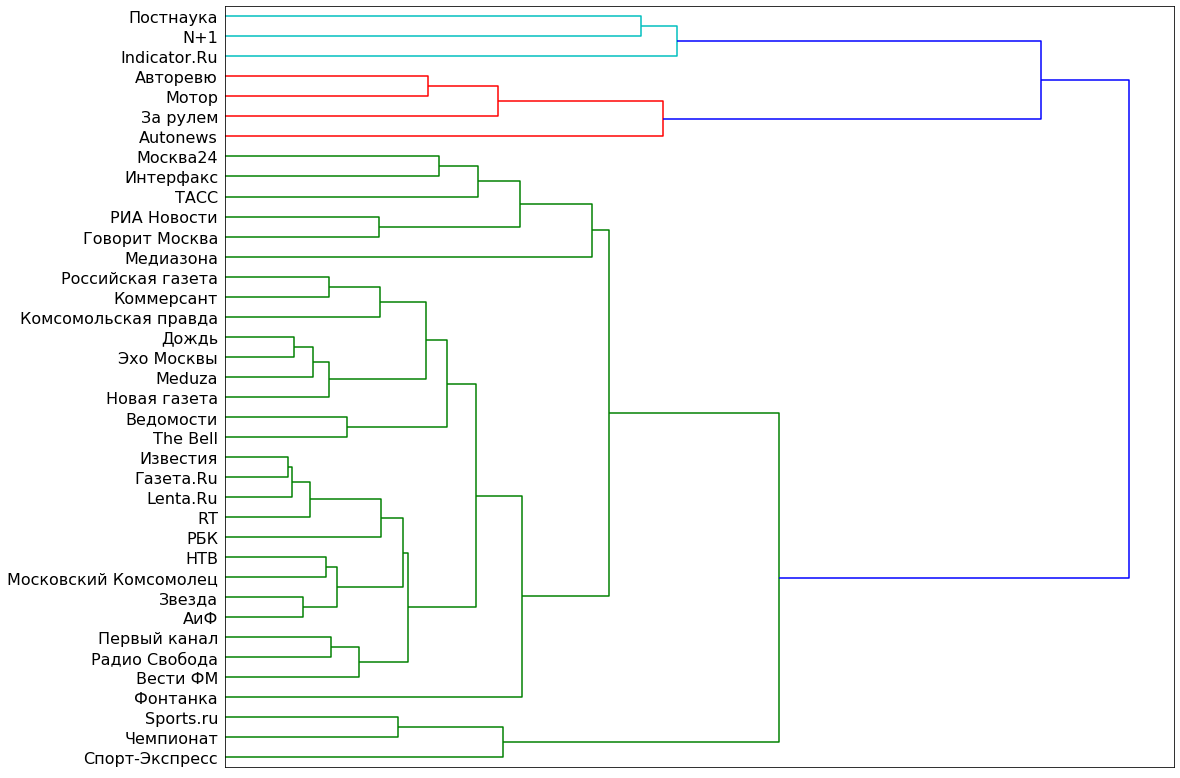

In [147]:
fig = plt.figure(figsize=(17, 14))
dendrogram = scipy.cluster.hierarchy.dendrogram(scipy.cluster.hierarchy.linkage(X, method='ward'), 
                                                orientation='right')
plt.tick_params(labelsize=16, axis='y', labelrotation=0)
plt.tick_params(labelsize=16, axis='x')
loc, lab = plt.yticks()
# l = {index:i for index, i in enumerate(df.columns[1:-1])}
l = {index:i for index, i in enumerate(media_list)}
labels_old = [i.get_text() for i in lab]
labels_new = [l[int(i)] for i in labels_old]
# print(labels_old, labels_new)
plt.yticks(loc, labels=labels_new);
plt.xticks([]);

## Quotations

In [103]:
def find_people(list_of_quotes, lang, sign):
    people = []
    morph = pymorphy2.MorphAnalyzer()
    
    if lang == 'en' and sign == 'hyphen':
        for quote in tqdm_notebook(list_of_quotes):
            quote = re.sub(r'".*"', r'"..."', quote)
            try:
                if not quote.endswith('"'):
                    author = re.findall(r'\b[А-Я]\w+\b', re.findall(r'", - .*', quote)[0])
                if quote.endswith('"') or not author:
                    author = re.findall(r'\b[А-Я]\w+\b', re.findall(r'.* "', quote)[0])
                for word in author:
                    m = morph.parse(word)[0]
                    if m.tag.animacy=='anim' and 'Name' not in m.tag:
                        people.append(m.normal_form.capitalize())
            except IndexError:
                pass
    
    elif lang == 'ru' and sign == 'hyphen':
        for quote in tqdm_notebook(list_of_quotes):
            quote = re.sub(r'«.*»', r'«...»', quote)
            try:
                if not quote.endswith('»'):
                    author = re.findall(r'\b[А-Я]\w+\b', re.findall(r'», - .*', quote)[0])
                if quote.endswith('»') or not author:
                    author = re.findall(r'\b[А-Я]\w+\b', re.findall(r'.* «', quote)[0])
                for word in author:
                    m = morph.parse(word)[0]
                    if m.tag.animacy=='anim' and 'Name' not in m.tag:
                        people.append(m.normal_form.capitalize())
            except IndexError:
                pass
    
    elif lang == 'ru' and sign == 'dash':
        for quote in tqdm_notebook(list_of_quotes):
            quote = re.sub(r'«.*»', r'«...»', quote)
            try:
                if not quote.endswith('»'):
                    author = re.findall(r'\b[А-Я]\w+\b', re.findall(r'», — .*', quote)[0])
                if quote.endswith('»') or not author:
                    author = re.findall(r'\b[А-Я]\w+\b', re.findall(r'.* «', quote)[0])
                for word in author:
                    m = morph.parse(word)[0]
                    if m.tag.animacy=='anim' and 'Name' not in m.tag:
                        people.append(m.normal_form.capitalize())
                    
            except IndexError:
                pass    

    return people

In [169]:
with open('tass_text.txt', encoding='utf-8') as f:
    tass_text = f.read()
    
tass_find = re.findall(r'[^\.]*\. "[^"]*", - [^\.]*', tass_text) + re.findall(r'[^\.]*: "[^"]*"', tass_text)
len(tass_find, '"', '-')

198414

In [182]:
Counter(find_people_en_hyphen(tass_find)).most_common(50)

[('Путин', 3007),
 ('Медведев', 1483),
 ('Лавров', 1206),
 ('Глава', 1002),
 ('Президент', 849),
 ('Володин', 658),
 ('Захаров', 571),
 ('Матвиенко', 514),
 ('Никитин', 459),
 ('Министр', 448),
 ('Кузнецов', 446),
 ('Иванов', 423),
 ('Собянин', 393),
 ('Лукашенко', 377),
 ('Слуцкий', 365),
 ('Волк', 349),
 ('Васильев', 347),
 ('Представитель', 330),
 ('Шойгу', 315),
 ('Порошенко', 315),
 ('Орешкин', 315),
 ('Косачев', 289),
 ('Морозов', 268),
 ('Премьер', 264),
 ('Рябок', 260),
 ('Орлов', 260),
 ('Голиков', 245),
 ('Столтенберг', 238),
 ('Антонов', 238),
 ('Председатель', 233),
 ('Макаров', 233),
 ('Рогозин', 228),
 ('Меркель', 224),
 ('Титов', 223),
 ('Петренко', 218),
 ('Губернатор', 212),
 ('Петров', 209),
 ('Попов', 209),
 ('Якушев', 193),
 ('Памфилов', 188),
 ('Патрушев', 187),
 ('Хуснуллин', 186),
 ('Сотрудник', 184),
 ('Толстой', 183),
 ('Осипов', 178),
 ('Волков', 177),
 ('Медведчук', 175),
 ('Мишустин', 172),
 ('Козак', 170),
 ('Греф', 159)]

In [64]:
def find_quotes(file, lang, sign):
    with open(file, encoding='utf-8') as f:
        text = f.read()
        
    if lang == 'en' and sign == 'hyphen':
        quotes = re.findall(r'[^\.]*\. "[^"]*", - [^\.]*', text) + re.findall(r'[^\.]*: "[^"]*"', text)
    elif lang == 'ru' and sign == 'hyphen':
        quotes = re.findall(r'[^\.]*\. «[^»]*», - [^\.]*', text) + re.findall(r'[^\.]*: «[^»]*»', text)
    elif lang == 'ru' and sign == 'dash':
        quotes = re.findall(r'[^\.]*\. «[^»]*», — [^\.]*', text) + re.findall(r'[^\.]*: «[^»]*»', text)
        
    print(len(quotes))
    return quotes

In [84]:
trials = dict()
for file in tqdm_notebook([file for file in os.listdir() if file.endswith('text.txt')][:-1]):
    media = file.split('_')[0]
    trials[media] = []
    try:
        print(file, 'ru', 'dash')
        quotes_temp = find_quotes(file, 'ru', 'dash')
        trials[media].append(quotes_temp)
    except (AttributeError, IndexError):
        print(error)
    try:   
        print(file, 'en','hyphen')
        quotes_temp = find_quotes(file, 'en','hyphen')
        trials[media].append(quotes_temp)
    except (AttributeError, IndexError):
        print(error)
    try:    
        print(file, 'ru', 'hyphen')
        quotes_temp = find_quotes(file, 'ru', 'hyphen')
        trials[media].append(quotes_temp)
    except (AttributeError, IndexError):
        print(error)
        
    with open('trials.json', 'w', encoding='utf-8') as f:
        json.dump(trials, f)

aif_text.txt ru dash
19619
aif_text.txt en hyphen
104
aif_text.txt ru hyphen
20672
autonews_text.txt ru dash
148
autonews_text.txt en hyphen
0
autonews_text.txt ru hyphen
5
championat_text.txt ru dash
8694
championat_text.txt en hyphen
2
championat_text.txt ru hyphen
3072
commers_text.txt ru dash
40681
commers_text.txt en hyphen
1138
commers_text.txt ru hyphen
38578
echo_text.txt ru dash
12206
echo_text.txt en hyphen
5
echo_text.txt ru hyphen
7637
express_text.txt ru dash
2482
express_text.txt en hyphen
0
express_text.txt ru hyphen
2417
fontanka_text.txt ru dash
8453
fontanka_text.txt en hyphen
430
fontanka_text.txt ru hyphen
5309
gazeta_text.txt ru dash
114603
gazeta_text.txt en hyphen
132
gazeta_text.txt ru hyphen
13025
govorit_text.txt ru dash
7521
govorit_text.txt en hyphen
57
govorit_text.txt ru hyphen
1333
indicator_text.txt ru dash
776
indicator_text.txt en hyphen
3
indicator_text.txt ru hyphen
199
interfax_text.txt ru dash
6
interfax_text.txt en hyphen
93796
interfax_text.txt r

In [114]:
for media in tqdm_notebook(trials.keys()):
    people = []
    
    people.extend(find_people(trials[media][0], 'ru', 'dash'))
    print(media, len(people))
    
    if trials[media][1]:
        people.extend(find_people(trials[media][1], 'en', 'hyphen'))
        print(media, len(people))
        
    people.extend(find_people(trials[media][2], 'ru', 'hyphen'))
    print(media, len(people))
    
    num_of_quotes = len(trials[media][0]) + len(trials[media][1]) + len(trials[media][2])

    speakers = dict()
    for k,v in dict(Counter(people)).items():
        speakers[k] = v/num_of_quotes

    result = sorted(speakers.items(), key=lambda x:x[1], reverse=True)
    pd.DataFrame(result).to_csv(f'{media}_people.csv', encoding='utf-8')


aif 7933



aif 7966



aif 16328



autonews 26



autonews 26



championat 3503



championat 3503



championat 4054



commers 18569



commers 18869



commers 36396



echo 3806



echo 3807



echo 6036



express 1390



express 2751



fontanka 2502



fontanka 2620



fontanka 4029



gazeta 44585



gazeta 44600



gazeta 48321



govorit 3348



govorit 3362



govorit 3917



indicator 266



indicator 267



indicator 303



interfax 2



interfax 32551



interfax 32581



iz 16970



iz 16970



iz 18422



kp 14311



kp 21468



kp 39182



lenta 17487



lenta 17574



lenta 18790



mediazona 3079



mediazona 3162



mediazona 4085



meduza 4210



meduza 4210



meduza 5832



mk 5299



mk 8803



mk 14257



motor 34



motor 35



motor 54



novaya 7007



novaya 7014



novaya 10548



nplus1 55



nplus1 71



ntv 11882



ntv 11882



ntv 23764



postnauka 132



postnauka 256



radiovesti 16



radiovesti 18



radiovesti 34



rbk 14027



rbk 14030



rbk 14769



review 17



review 32



ria 1



ria 54492



ria 54493



rosgazeta 4



rosgazeta 24043



rosgazeta 24049



rt 26840



rt 26842



rt 27476



sports 24438



sports 24438



sports 48697



svoboda 303



svoboda 3980



svoboda 4274



tass 18



tass 65985



tass 65999



thebell 439



thebell 571



tv1 10575



tv1 10687



tv1 13611



tvrain 2451



tvrain 2456



tvrain 3020



vedomosti 3398



vedomosti 3410



vedomosti 6604



zarulem 120



zarulem 195



zvezda 329



zvezda 410



zvezda 12263



In [2]:
keyspeakers_set = set()
for file in [file for file in os.listdir() if file.endswith('people.csv')]:
    df = pd.read_csv(file)
    keyspeakers_set.update(list(df['0'][:100]))
len(keyspeakers_set)

1102

In [4]:
keys = pd.DataFrame(keyspeakers_set)
for file in [file for file in os.listdir() if file.endswith('people.csv')]:
    media = file.split('_')[0]
    df = pd.read_csv(file)
    if 'Unnamed: 0' in df.columns:
        df.drop(['Unnamed: 0'], axis=1, inplace=True)
    try:
        keys = keys.merge(df, how='left', left_on=0, right_on='0').drop(['0'], axis=1).rename(columns={'1':media})
    except KeyError:
        print(file) 
    
keys.to_csv('people_top_100_set.csv')

In [116]:
# keys = keys.fillna(0)
# keys['sum'] = keys.sum(axis=1)
# keys.sort_values('sum', ascending=False).rename(columns={0:'person'}).to_csv('people_top_100_set_sorted.csv')
keys.sort_values('sum', ascending=False).rename(columns={0:'person'})

,person,aif,autonews,championat,commers,echo,express,fontanka,gazeta,govorit,indicator,interfax,iz,kp,lenta,mediazona,meduza,mk,moscow,motor,novaya,nplus1,ntv,postnauka,radiovesti,rbk,review,ria,rosgazeta,rt,sports,svoboda,tass,thebell,tv1,tvrain,vedomosti,zarulem,zvezda,sum
345,Путин,0.012625,0.0,0.001869,0.006232,0.017029,0.000000,0.016700,0.020938,0.038604,0.003067,0.025029,0.016232,0.007363,0.013527,0.007647,0.008743,0.020454,0.001423,0.0,0.009001,0.0,0.050153,0.0,0.016129,0.024317,0.0,0.027383,0.034600,0.017061,0.000903,0.017588,0.015160,0.029851,0.113445,0.033038,0.029357,0.0,0.029415,0.664883
489,Медведев,0.004654,0.0,0.007308,0.002388,0.002469,0.006124,0.004298,0.007577,0.010885,0.002045,0.007651,0.004186,0.002431,0.004279,0.000101,0.001557,0.004620,0.000289,0.0,0.002267,0.0,0.010582,0.0,0.064516,0.006978,0.0,0.009812,0.012911,0.003724,0.006553,0.005163,0.007472,0.010333,0.024255,0.005324,0.003281,0.0,0.004424,0.250457
940,Президент,0.007154,0.0,0.003824,0.004329,0.004182,0.006124,0.002396,0.003546,0.004152,0.002045,0.009547,0.004155,0.003468,0.001980,0.001207,0.001677,0.003546,0.000467,0.0,0.003067,0.0,0.000824,0.0,0.000000,0.005582,0.0,0.009068,0.005629,0.001273,0.006374,0.003588,0.004288,0.004592,0.002936,0.006143,0.005625,0.0,0.003587,0.126375
142,Порошенко,0.004456,0.0,0.000000,0.001144,0.002166,0.000000,0.002607,0.008164,0.005162,0.000000,0.003271,0.004871,0.003730,0.005145,0.000000,0.000599,0.001798,0.000000,0.0,0.001933,0.0,0.008153,0.0,0.032258,0.005464,0.0,0.003776,0.001439,0.006164,0.000000,0.001925,0.001587,0.005166,0.004893,0.001502,0.002871,0.0,0.005321,0.125568
567,Глава,0.006932,0.0,0.003229,0.007637,0.001713,0.001633,0.004157,0.003820,0.005723,0.000000,0.005125,0.004202,0.003747,0.003890,0.003823,0.003353,0.003546,0.000934,0.0,0.002967,0.0,0.002018,0.0,0.000000,0.006174,0.0,0.005802,0.005301,0.002051,0.003308,0.001750,0.005048,0.001148,0.001328,0.006280,0.000879,0.0,0.003916,0.111435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,Ризнич,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000600,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000600
539,Асафов,0.000025,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000463,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000090,0.000585
982,Коммунарка,0.000000,0.0,0.000000,0.000000,0.000050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000016,0.000000,0.000018,0.000000,0.000000,0.000000,0.000356,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000007,0.000000,0.000095,0.000000,0.000000,0.000020,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000561
248,Марьин,0.000000,0.0,0.000000,0.000000,0.000101,0.000000,0.000000,0.000008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000334,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000007,0.000000,0.000000,0.000000,0.000000,0.000005,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000454


In [148]:
r = pd.read_csv('people_top_100_set_sorted.csv')
r.drop(['Unnamed: 0'], axis=1, inplace=True)
r

,person,aif,autonews,championat,commers,echo,express,fontanka,gazeta,govorit,indicator,interfax,iz,kp,lenta,mediazona,meduza,mk,moscow,motor,novaya,nplus1,ntv,postnauka,radiovesti,rbk,review,ria,rosgazeta,rt,sports,svoboda,tass,thebell,tv1,tvrain,vedomosti,zarulem,zvezda,sum
0,Путин,0.012625,0.0,0.001869,0.006232,0.017029,0.000000,0.016700,0.020938,0.038604,0.003067,0.025029,0.016232,0.007363,0.013527,0.007647,0.008743,0.020454,0.001423,0.0,0.009001,0.0,0.050153,0.0,0.016129,0.024317,0.0,0.027383,0.034600,0.017061,0.000903,0.017588,0.015160,0.029851,0.113445,0.033038,0.029357,0.0,0.029415,0.664883
1,Медведев,0.004654,0.0,0.007308,0.002388,0.002469,0.006124,0.004298,0.007577,0.010885,0.002045,0.007651,0.004186,0.002431,0.004279,0.000101,0.001557,0.004620,0.000289,0.0,0.002267,0.0,0.010582,0.0,0.064516,0.006978,0.0,0.009812,0.012911,0.003724,0.006553,0.005163,0.007472,0.010333,0.024255,0.005324,0.003281,0.0,0.004424,0.250457
2,Президент,0.007154,0.0,0.003824,0.004329,0.004182,0.006124,0.002396,0.003546,0.004152,0.002045,0.009547,0.004155,0.003468,0.001980,0.001207,0.001677,0.003546,0.000467,0.0,0.003067,0.0,0.000824,0.0,0.000000,0.005582,0.0,0.009068,0.005629,0.001273,0.006374,0.003588,0.004288,0.004592,0.002936,0.006143,0.005625,0.0,0.003587,0.126375
3,Порошенко,0.004456,0.0,0.000000,0.001144,0.002166,0.000000,0.002607,0.008164,0.005162,0.000000,0.003271,0.004871,0.003730,0.005145,0.000000,0.000599,0.001798,0.000000,0.0,0.001933,0.0,0.008153,0.0,0.032258,0.005464,0.0,0.003776,0.001439,0.006164,0.000000,0.001925,0.001587,0.005166,0.004893,0.001502,0.002871,0.0,0.005321,0.125568
4,Глава,0.006932,0.0,0.003229,0.007637,0.001713,0.001633,0.004157,0.003820,0.005723,0.000000,0.005125,0.004202,0.003747,0.003890,0.003823,0.003353,0.003546,0.000934,0.0,0.002967,0.0,0.002018,0.0,0.000000,0.006174,0.0,0.005802,0.005301,0.002051,0.003308,0.001750,0.005048,0.001148,0.001328,0.006280,0.000879,0.0,0.003916,0.111435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,Ризнич,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000600,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000600
1098,Асафов,0.000025,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000463,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000090,0.000585
1099,Коммунарка,0.000000,0.0,0.000000,0.000000,0.000050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000016,0.000000,0.000018,0.000000,0.000000,0.000000,0.000356,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000007,0.000000,0.000095,0.000000,0.000000,0.000020,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000561
1100,Марьин,0.000000,0.0,0.000000,0.000000,0.000101,0.000000,0.000000,0.000008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000334,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000007,0.000000,0.000000,0.000000,0.000000,0.000005,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000454


In [149]:
for media in r.columns[1:-1]:
    r = r.sort_values(media, ascending=False)
    r[media]/=r[media].iloc[0]
r.sort_values('sum', ascending=False)

,person,aif,autonews,championat,commers,echo,express,fontanka,gazeta,govorit,indicator,interfax,iz,kp,lenta,mediazona,meduza,mk,moscow,motor,novaya,nplus1,ntv,postnauka,radiovesti,rbk,review,ria,rosgazeta,rt,sports,svoboda,tass,thebell,tv1,tvrain,vedomosti,zarulem,zvezda,sum
0,Путин,1.000000,0.0,0.255814,0.564189,1.000000,0.000000,1.000000,1.000000,1.000000,0.3,1.000000,1.000000,1.000000,1.000000,0.800000,1.000000,1.000000,0.119403,0.0,1.000000,0.0,1.000000,0.0,0.166667,1.000000,0.0,1.000000,1.000000,1.000000,0.080979,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.664883
1,Медведев,0.368627,0.0,1.000000,0.216216,0.144970,0.625000,0.257384,0.361869,0.281977,0.2,0.305662,0.257910,0.330178,0.316340,0.010526,0.178082,0.225885,0.024254,0.0,0.251852,0.0,0.211002,0.0,0.666667,0.286965,0.0,0.358329,0.373147,0.218249,0.587571,0.293532,0.492855,0.346154,0.213802,0.161157,0.111776,0.0,0.150407,0.250457
2,Президент,0.566667,0.0,0.523256,0.391892,0.245562,0.625000,0.143460,0.169346,0.107558,0.2,0.381439,0.255992,0.471006,0.146405,0.126316,0.191781,0.173382,0.039179,0.0,0.340741,0.0,0.016420,0.0,0.000000,0.229572,0.0,0.331152,0.162685,0.074599,0.571563,0.203980,0.282818,0.153846,0.025878,0.185950,0.191617,0.0,0.121951,0.126375
3,Порошенко,0.352941,0.0,0.000000,0.103604,0.127219,0.000000,0.156118,0.389907,0.133721,0.0,0.130694,0.300096,0.506509,0.380392,0.000000,0.068493,0.087912,0.000000,0.0,0.214815,0.0,0.162562,0.0,0.333333,0.224708,0.0,0.137896,0.041598,0.361282,0.000000,0.109453,0.104686,0.173077,0.043130,0.045455,0.097804,0.0,0.180894,0.125568
4,Глава,0.549020,0.0,0.441860,0.691441,0.100592,0.166667,0.248945,0.182430,0.148256,0.0,0.204768,0.258869,0.508876,0.287582,0.400000,0.383562,0.173382,0.078358,0.0,0.329630,0.0,0.040230,0.0,0.000000,0.253891,0.0,0.211877,0.153213,0.120222,0.296610,0.099502,0.333001,0.038462,0.011707,0.190083,0.029940,0.0,0.133130,0.111435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,Ризнич,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.066667,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000600
1098,Асафов,0.001961,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000374,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.027127,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.003049,0.000585
1099,Коммунарка,0.000000,0.0,0.000000,0.000000,0.002959,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000959,0.000000,0.001307,0.000000,0.000000,0.000000,0.029851,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000252,0.000000,0.005549,0.000000,0.000000,0.001329,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000561
1100,Марьин,0.000000,0.0,0.000000,0.000000,0.005917,0.000000,0.000000,0.000374,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027985,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000252,0.000000,0.000000,0.000000,0.000000,0.000332,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000454


In [150]:
r.columns

Index(['person', 'aif', 'autonews', 'championat', 'commers', 'echo', 'express',
       'fontanka', 'gazeta', 'govorit', 'indicator', 'interfax', 'iz', 'kp',
       'lenta', 'mediazona', 'meduza', 'mk', 'moscow', 'motor', 'novaya',
       'nplus1', 'ntv', 'postnauka', 'radiovesti', 'rbk', 'review', 'ria',
       'rosgazeta', 'rt', 'sports', 'svoboda', 'tass', 'thebell', 'tv1',
       'tvrain', 'vedomosti', 'zarulem', 'zvezda', 'sum'],
      dtype='object')

In [151]:
media_list = ['АиФ', 'Autonews', 'Чемпионат', 'Коммерсант', 'Эхо Москвы', 'Спорт-Экспресс',
       'Фонтанка', 'Газета.Ru', 'Говорит Москва', 'Indicator.Ru', 'Интерфакс', 'Известия', 'Комсомольская правда',
       'Lenta.Ru', 'Медиазона', 'Meduza', 'Московский Комсомолец', 'Москва24', 'Мотор', 'Новая газета',
       'N+1', 'НТВ', 'Постнаука', 'Вести ФМ', 'РБК', 'Авторевю', 'РИА Новости',
       'Российская газета', 'RT', 'Sports.ru', 'Радио Свобода', 'ТАСС', 'The Bell', 'Первый канал',
       'Дождь', 'Ведомости', 'За рулем', 'Звезда']

In [152]:
X = r.iloc[:, 1:-1].values.T

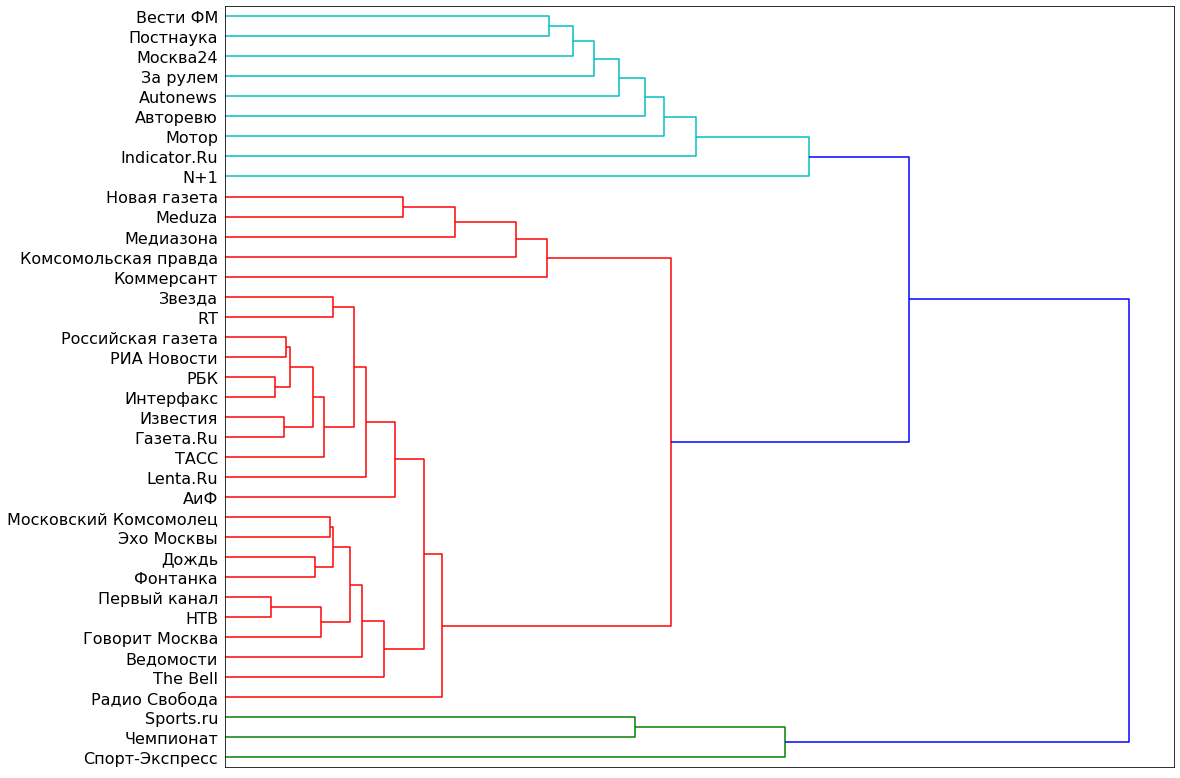

In [155]:
fig = plt.figure(figsize=(17, 14))
dendrogram = scipy.cluster.hierarchy.dendrogram(scipy.cluster.hierarchy.linkage(X, method='ward'), 
                                                orientation='right',
                                                distance_sort='ascending')
plt.tick_params(labelsize=16, axis='y', labelrotation=0)
plt.tick_params(labelsize=16, axis='x')
loc, lab = plt.yticks()
l = {index:i for index, i in enumerate(media_list)}
labels_old = [i.get_text() for i in lab]
labels_new = [l[int(i)] for i in labels_old]
plt.yticks(loc, labels=labels_new);
plt.xticks([]);

## Topic Modelling

In [5]:
for_topics_2 = pd.DataFrame()
for media in tqdm_notebook(media_outlets):
    size_of_sample = math.floor(1000/len(media_outlets[media]))
    for file in tqdm_notebook(media_outlets[media]):
        try:
            df = pd.read_csv(file)
            if size_of_sample > len(df):
                size_of_sample = len(df)
            sample = random.sample(list(range(len(df))), size_of_sample)
            df_100 = df.iloc[sample][['Media', 'Text']]
            for_topics_2 = pd.concat([for_topics_2, df_100])
        except FileNotFoundError:
            print(file)
for_topics_2.to_csv('for_topics_2.csv')
len(for_topics_2)

36853

In [73]:
texts = list(for_topics_2['Text'][for_topics_2['Text'].notna()])

In [75]:
vectorizer = CountVectorizer(stop_words = stopwords, max_features = 1000)

In [76]:
X_2 = vectorizer.fit_transform(texts)

In [ ]:
clustering = agg_clustering(n_clusters=15).fit(X_2.toarray())

In [ ]:
for_topics_2 = for_topics_2[for_topics_2['Text'].notna()]
for_topics_2.to_csv('for_topics_2.csv')

In [14]:
for_topics_2 = pd.read_csv('for_topics_2.csv')

In [ ]:
for_topics_2['Label'] = clustering.labels_

In [ ]:
topics_2 = []
for media in for_topics_2.Media.unique():
    template = {k:0 for k in range(15)}
    template.update(dict(for_topics_2[for_topics_2['Media'] == media].groupby('Label')['Label'].count()))
    topics_2.append(list(template.values()))

In [16]:
topics_2 = pd.read_csv('topics_2_raw.csv')
topics_2.drop(['Unnamed: 0'], axis=1, inplace=True)
topics_2 = topics_2.astype(float)
topics_2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,26.0,731.0,109.0,0.0,0.0,59.0,0.0,2.0,0.0,61.0,0.0,5.0,7.0,0.0
1,2.0,28.0,714.0,104.0,0.0,2.0,20.0,0.0,9.0,0.0,91.0,4.0,8.0,8.0,0.0
2,0.0,44.0,632.0,83.0,0.0,3.0,40.0,0.0,9.0,0.0,171.0,5.0,6.0,7.0,0.0
3,0.0,25.0,791.0,107.0,0.0,1.0,27.0,0.0,13.0,0.0,16.0,1.0,4.0,12.0,1.0
4,0.0,54.0,700.0,96.0,0.0,19.0,29.0,1.0,56.0,0.0,7.0,7.0,18.0,13.0,0.0
5,0.0,23.0,829.0,86.0,0.0,0.0,27.0,0.0,17.0,0.0,6.0,0.0,2.0,8.0,0.0
6,0.0,20.0,844.0,58.0,0.0,0.0,45.0,0.0,9.0,0.0,14.0,1.0,3.0,6.0,0.0
7,0.0,18.0,820.0,82.0,0.0,4.0,30.0,0.0,20.0,0.0,9.0,2.0,2.0,13.0,0.0
8,0.0,4.0,874.0,24.0,0.0,0.0,47.0,0.0,0.0,0.0,46.0,1.0,1.0,3.0,0.0
9,0.0,28.0,871.0,23.0,0.0,0.0,55.0,0.0,5.0,0.0,12.0,1.0,2.0,3.0,0.0


In [17]:
topics_2 = list([list(i) for i in topics_2.values])
topics_2

[[0.0,
  26.0,
  731.0,
  109.0,
  0.0,
  0.0,
  59.0,
  0.0,
  2.0,
  0.0,
  61.0,
  0.0,
  5.0,
  7.0,
  0.0],
 [2.0,
  28.0,
  714.0,
  104.0,
  0.0,
  2.0,
  20.0,
  0.0,
  9.0,
  0.0,
  91.0,
  4.0,
  8.0,
  8.0,
  0.0],
 [0.0,
  44.0,
  632.0,
  83.0,
  0.0,
  3.0,
  40.0,
  0.0,
  9.0,
  0.0,
  171.0,
  5.0,
  6.0,
  7.0,
  0.0],
 [0.0,
  25.0,
  791.0,
  107.0,
  0.0,
  1.0,
  27.0,
  0.0,
  13.0,
  0.0,
  16.0,
  1.0,
  4.0,
  12.0,
  1.0],
 [0.0,
  54.0,
  700.0,
  96.0,
  0.0,
  19.0,
  29.0,
  1.0,
  56.0,
  0.0,
  7.0,
  7.0,
  18.0,
  13.0,
  0.0],
 [0.0,
  23.0,
  829.0,
  86.0,
  0.0,
  0.0,
  27.0,
  0.0,
  17.0,
  0.0,
  6.0,
  0.0,
  2.0,
  8.0,
  0.0],
 [0.0,
  20.0,
  844.0,
  58.0,
  0.0,
  0.0,
  45.0,
  0.0,
  9.0,
  0.0,
  14.0,
  1.0,
  3.0,
  6.0,
  0.0],
 [0.0,
  18.0,
  820.0,
  82.0,
  0.0,
  4.0,
  30.0,
  0.0,
  20.0,
  0.0,
  9.0,
  2.0,
  2.0,
  13.0,
  0.0],
 [0.0,
  4.0,
  874.0,
  24.0,
  0.0,
  0.0,
  47.0,
  0.0,
  0.0,
  0.0,
  46.0,
  1.0,
  1.0

In [18]:
for indexi, i in enumerate(topics_2):
    topics_2[indexi]/=max(i)
topics_2

[array([0.        , 0.03556772, 1.        , 0.14911081, 0.        ,
        0.        , 0.08071135, 0.        , 0.00273598, 0.        ,
        0.08344733, 0.        , 0.00683995, 0.00957592, 0.        ]),
 array([0.00280112, 0.03921569, 1.        , 0.14565826, 0.        ,
        0.00280112, 0.0280112 , 0.        , 0.01260504, 0.        ,
        0.12745098, 0.00560224, 0.01120448, 0.01120448, 0.        ]),
 array([0.        , 0.06962025, 1.        , 0.13132911, 0.        ,
        0.00474684, 0.06329114, 0.        , 0.01424051, 0.        ,
        0.27056962, 0.00791139, 0.00949367, 0.01107595, 0.        ]),
 array([0.        , 0.03160556, 1.        , 0.13527181, 0.        ,
        0.00126422, 0.03413401, 0.        , 0.01643489, 0.        ,
        0.02022756, 0.00126422, 0.00505689, 0.01517067, 0.00126422]),
 array([0.        , 0.07714286, 1.        , 0.13714286, 0.        ,
        0.02714286, 0.04142857, 0.00142857, 0.08      , 0.        ,
        0.01      , 0.01      , 0.025714

In [19]:
media_list = for_topics_2.Media.unique()

In [20]:
media_dict = {'tass.ru':'ТАСС', 'kommersant.ru':'Коммерсант', 'vedomosti.ru':'Ведомости', 'rg.ru':'Российская газета',
       'novayagazeta.ru':'Новая газета', 'aif.ru':'АиФ', 'izvestiya.ru':'Известия', 'mk.ru':'Московский Комсомолец', 'rbc.ru':'РБК',
       'russian.rt.com':'RT', 'lenta.ru':'Lenta.Ru', 'meduza.io':'Meduza', '1tv.ru':'Первый канал', 'ntv.ru':'НТВ',
       'tvzvezda.ru':'Звезда', 'tvrain.ru':'Дождь', 'govoritmoskva.ru':'Говорит Москва', 'echo.msk.ru':'Эхо Москвы',
       'svoboda.org':'Радио Свобода', 'radiovesti.ru':'Вести ФМ', 'autonews.ru':'Autonews', 'zr.ru':'За рулем',
       'autoreview.ru':'Авторевю', 'sport-express.ru':'Спорт-Экспресс', 'championat.ru':'Чемпионат', 'nplus1.ru':'N+1',
       'postnauka.ru':'Постнаука', 'indicator.ru':'Indicator.Ru', 'interfax.ru':'Интерфакс', 'gazeta.ru':'Газета.Ru',
       'zona.media':'Медиазона', 'thebell.io':'The Bell', 'motor.ru':'Мотор', 'ria.ru':'РИА Новости', 'kp.ru':'Комсомольская правда',
       'sports.ru':'Sports.ru', 'fontanka.ru':'Фонтанка', 'mskagency.ru':'Агентство Москва'}

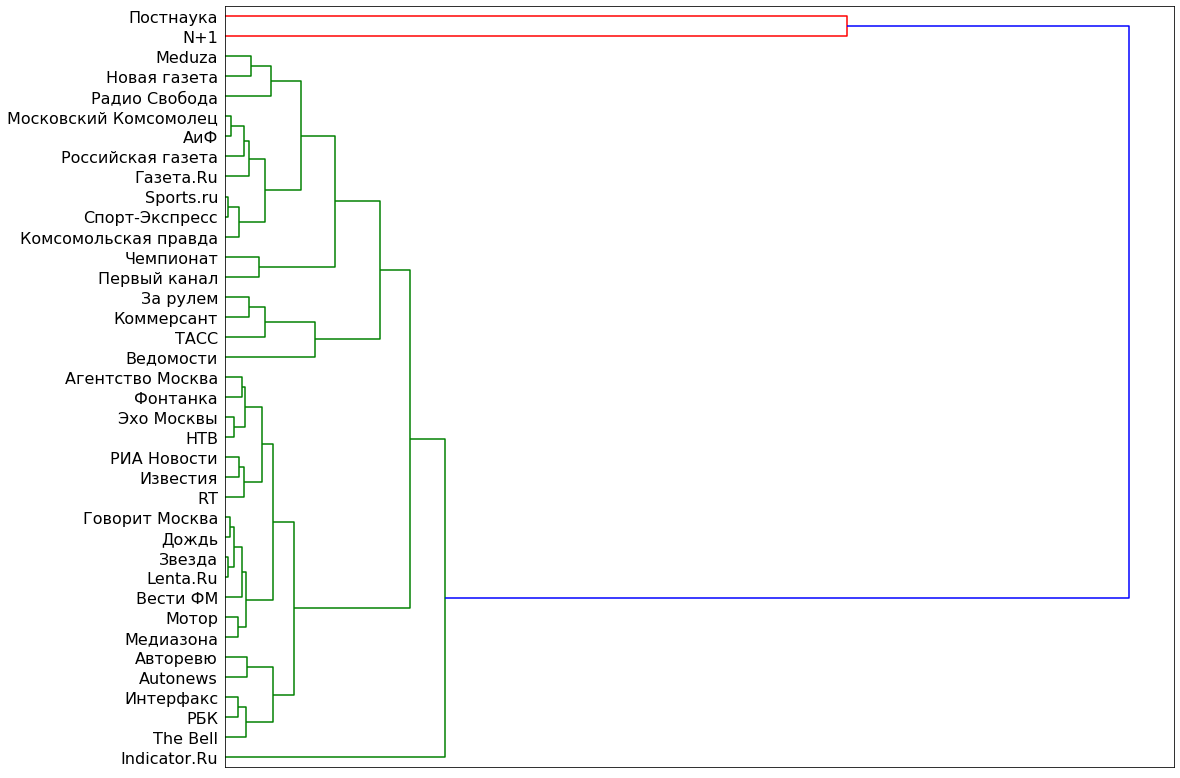

In [21]:
fig = plt.figure(figsize=(17, 14))
dendrogram = scipy.cluster.hierarchy.dendrogram(scipy.cluster.hierarchy.linkage(topics_2, method='ward'), 
                                                orientation='right',
                                                distance_sort='ascending')
plt.tick_params(labelsize=16, axis='y', labelrotation=0)
plt.tick_params(labelsize=16, axis='x')
loc, lab = plt.yticks()
l = {index:media_dict[i] for index, i in enumerate(media_list)}
labels_old = [i.get_text() for i in lab]
labels_new = [l[int(i)] for i in labels_old]
plt.yticks(loc, labels=labels_new);
plt.xticks([]);